[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/weaviate/recipes/blob/main/integrations/operations/langtrace/weaviate_observability.ipynb)

# 1. Setup Langtrace & Weaviate

- Sign-up for a free account on [Langtrace](https://langtrace.ai).

- Create a Project and generate an [API Key](https://docs.langtrace.ai/quickstart#langtrace-cloud).

- Create a [Weaviate Cloud](https://weaviate.io/)cluster.

# 2. Import Dependencies

In [ ]:
%pip install weaviate-client==4.6.4 langtrace-python-sdk==2.1.14

In [ ]:
# NOTE: this may require a restart after running, restart and proceed to next step (this is a fix for Google collab)
%pip install protobuf==3.20.3

  Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-health-checking 1.62.2 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
grpcio-tools 1.62.2 requires protobuf<5.0dev,>=4.21.6, but you have protobuf 3.20.3 which is incompatible.


# 3. Export Env vars

In [ ]:
# export Weaviate cloud env vars
%env WCS_DEMO_URL=<Weaviate Cluster URL>
%env WCS_DEMO_RO_KEY=<Weaviate Cluster Key>

%env OPENAI_API_KEY=sk-<OPENAI KEY>
%env LANGTRACE_API_KEY=<LANGTRACE API KEY>

In [ ]:
import json
import os
import logging
import sys
from pathlib import Path

import requests
import weaviate
import weaviate.classes as wvc
from weaviate.classes.aggregate import GroupByAggregate
from weaviate.classes.query import Filter, HybridFusion, MetadataQuery
from weaviate.collections.classes.grpc import Move

import langtrace_python_sdk.langtrace as langtrace
from langtrace_python_sdk import with_langtrace_root_span

## Initialize Weaviate & Langtrace

In [ ]:
client = weaviate.connect_to_wcs(
    cluster_url=os.environ["WCS_DEMO_URL"],
    auth_credentials=weaviate.auth.AuthApiKey(os.environ["WCS_DEMO_RO_KEY"]),
    skip_init_checks=True,
    headers={"X-OpenAI-Api-Key": os.environ["OPENAI_API_KEY"]},
)

langtrace.init()

# 4. Create a collection and insert data


In [ ]:
collection_name="JeopardyQuestions"

def create_collection():
  # Creates a collection
  client.collections.create(
          name=collection_name,
          # Set the vectorizer to "text2vec-openai" to use the OpenAI API for vector-related operations
          vectorizer_config=wvc.config.Configure.Vectorizer.text2vec_openai(),
          # Ensure the `generative-openai` module is used for generative queries
          generative_config=wvc.config.Configure.Generative.openai(),
      )
  print(f"Collection {collection_name} created!")

def insert_data():
  resp = requests.get(
          "https://raw.githubusercontent.com/weaviate-tutorials/quickstart/main/data/jeopardy_tiny.json"
      )
  data = json.loads(resp.text)  # Load data

  question_objs = list()
  for i, d in enumerate(data):
      question_objs.append(
          {
              "answer": d["Answer"],
              "question": d["Question"],
              "category": d["Category"],
          }
      )

  questions = client.collections.get(collection_name)
  questions.data.insert_many(question_objs)
  print(f"Data inserted into collection {collection_name}.")

create_collection()
insert_data()

Collection JeopardyQuestions created!
Data inserted into collection JeopardyQuestions.


# 5. Query the collection using near_text

In [ ]:
@with_langtrace_root_span()
def query_collections():
  questions = client.collections.get(collection_name)
  response = questions.query.near_text(
      query="history",
      limit=2,
  )
  print(response)
  for each_obj in response.objects:
      print(each_obj.properties)

query_collections()

QueryReturn(objects=[Object(uuid=_WeaviateUUIDInt('0512b14a-419a-470d-aa89-84124112750e'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=None, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'category': 'SCIENCE', 'answer': 'DNA', 'question': 'In 1953 Watson & Crick built a model of the molecular structure of this, the gene-carrying substance'}, references=None, vector={}, collection='JeopardyQuestions'), Object(uuid=_WeaviateUUIDInt('c533219b-1165-4ac5-81dd-8211bd232303'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=None, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'question': "2000 news: the Gunnison sage grouse isn't just another northern sage grouse, but a new one of this classification", 'category': 'SCIENCE', 'answer': 'species'}, references=None, vector={}, collection='JeopardyQuestions')])
{'category': 'SCIENCE

# Conclusion
### You should now see traces appearing on your Langtrace dashboard!
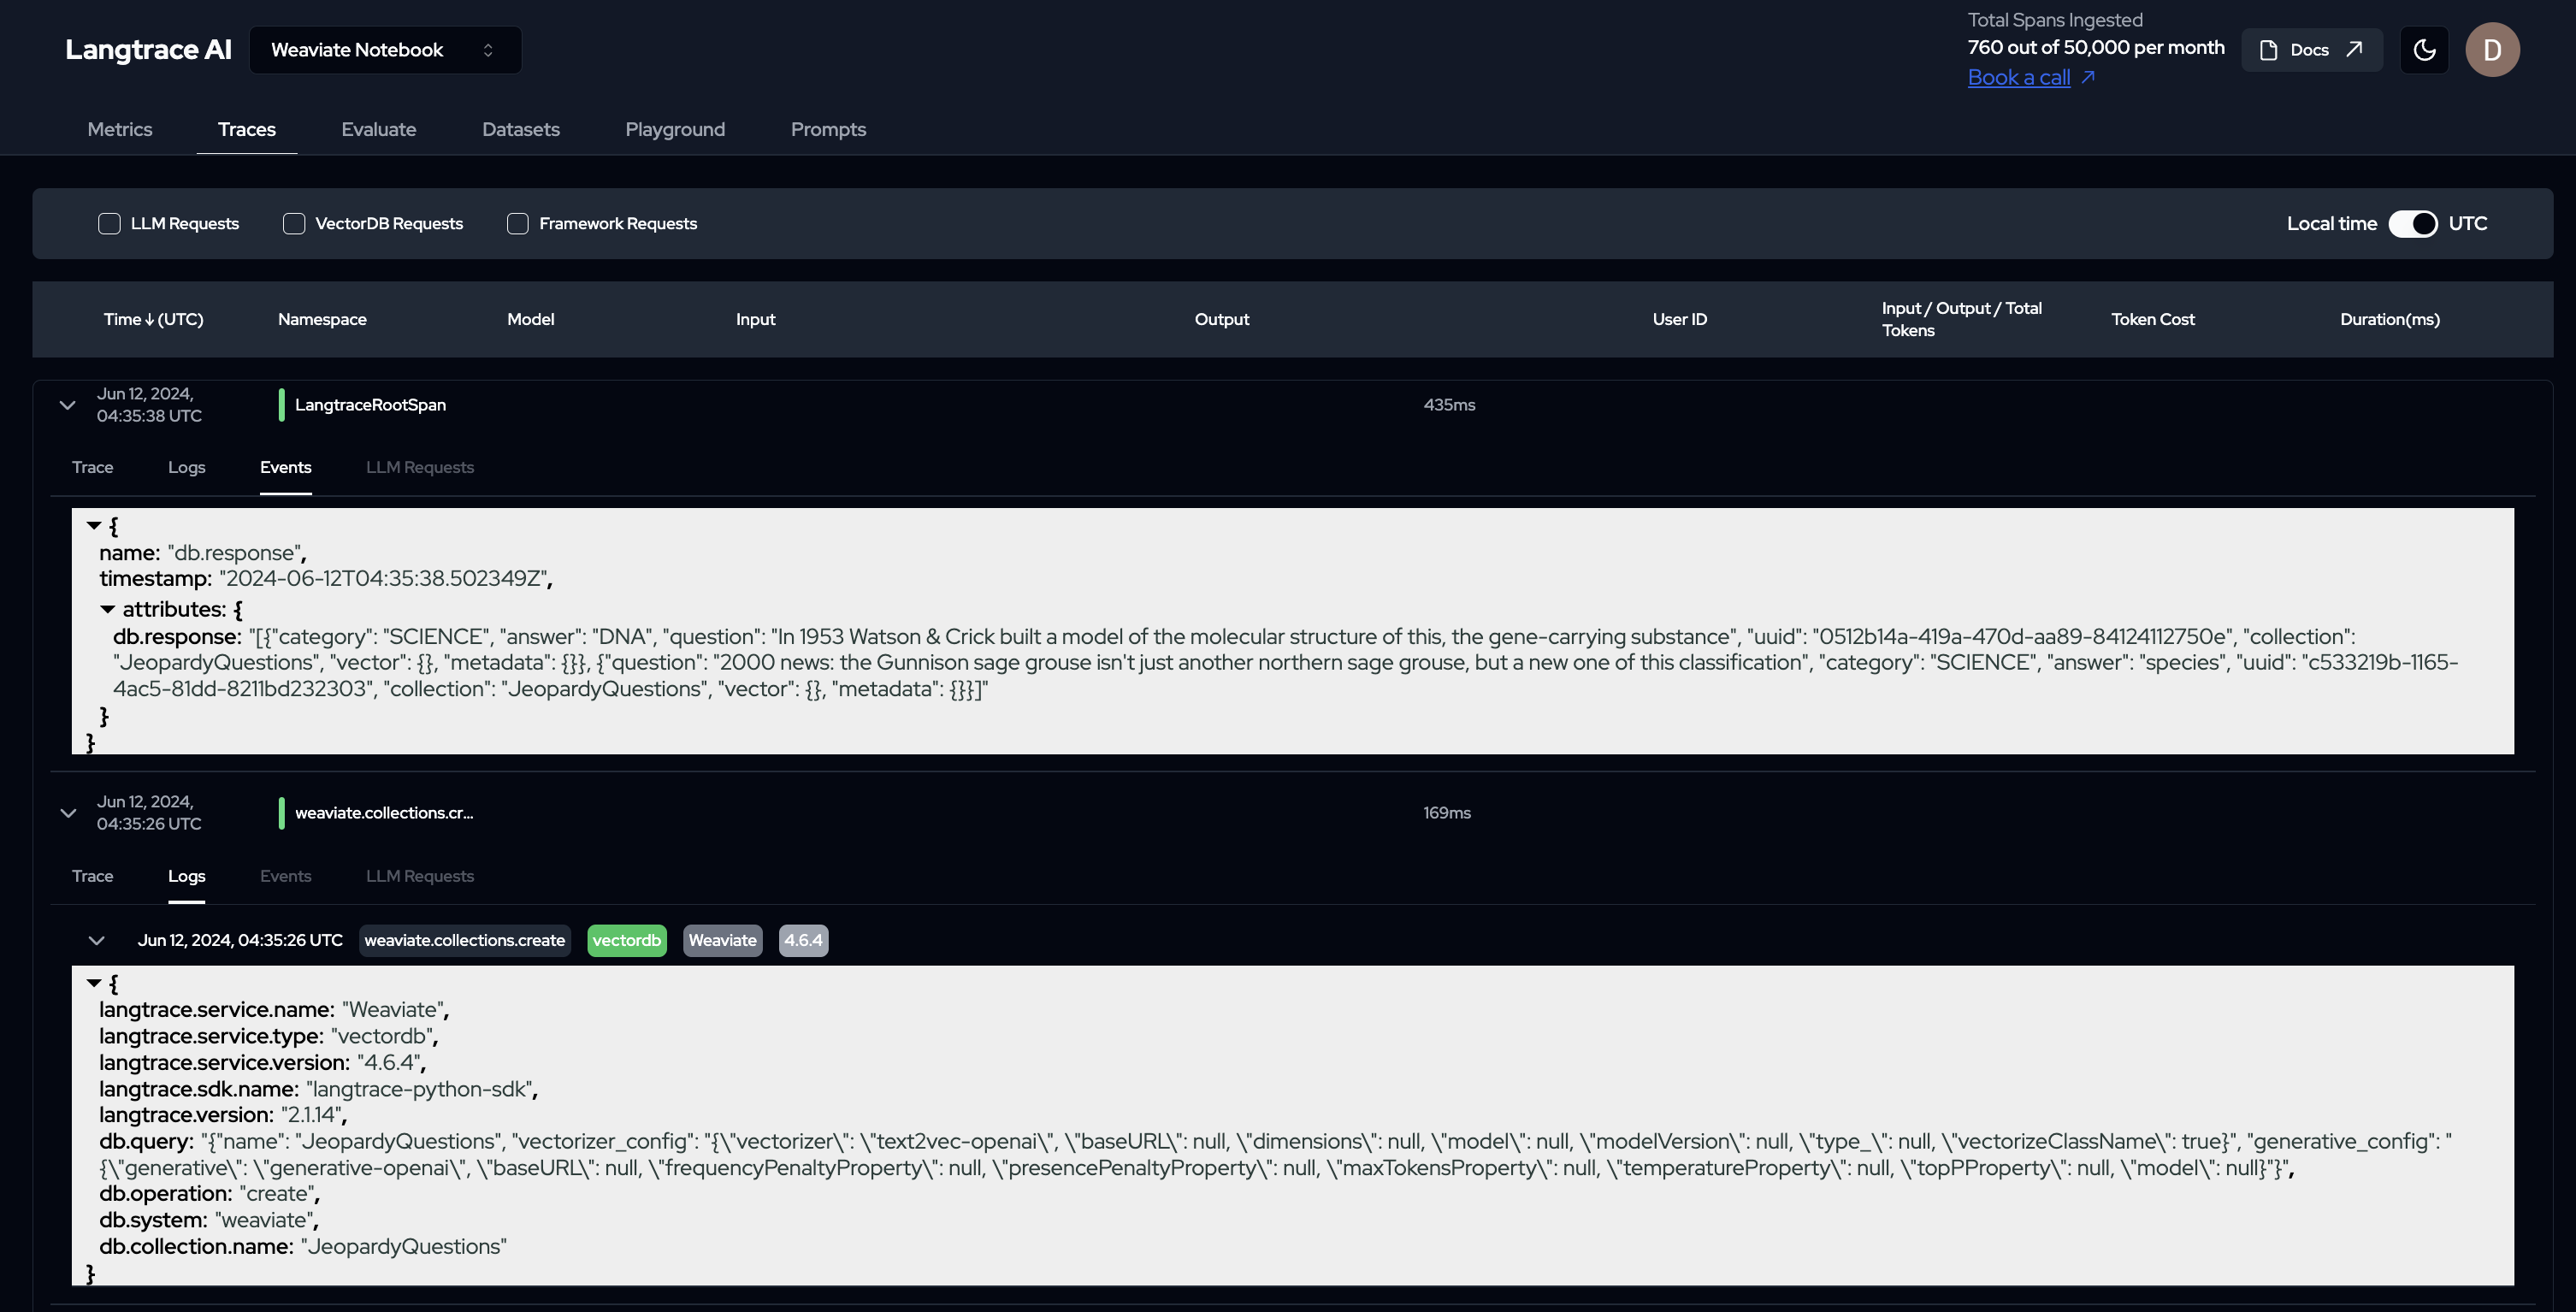

<br>
<br>

## Interested to dive deep into weaviate instrumentation?
Check out our [Weaviate docs](https://docs.langtrace.ai/supported-integrations/vector-stores/weaviate) or a hands on video for instrumenting Weaviate API calls [here](https://youtu.be/qPhWr0A0t98).